In [ ]:

from metavision_sdk_cv import SpatioTemporalContrastAlgorithm, \
    SparseOpticalFlowAlgorithm, SparseOpticalFlowConfigPreset
from metavision_core.event_io import EventsIterator
import numpy as np
import matplotlib.pyplot as plt
import scienceplots
from matplotlib import rcParams
import os
import datetime
import bisect
import requests
from skimage import measure
from plotting import set_plotting_style

set_plotting_style(plt)



acc_time = 10 # Accumulation time in microseconds
# D:\CZI_scope\code\data\raw\recording_2024-07-16_13-37-32.raw 29031937
# D:\CZI_scope\code\data\raw\recording_2024-07-16_13-39-21.raw
# D:\CZI_scope\code\data\raw\recording_2024-07-16_11-33-44.raw 150562818
input_path = input('Enter the path to the file: ').strip()  # Path to the file
width = 640
height = 480
processing_ts = 0
disable_stc = False

accumulated_slices = []


stc_filter = SpatioTemporalContrastAlgorithm(
    width, height, 15000, True)

start_ts = int(((149930901) // acc_time) * acc_time)
print(f'Starting at {start_ts}')
mv_iterator = EventsIterator(
    input_path=input_path, delta_t=acc_time, start_ts=start_ts, max_duration=100e3)
flow_algo = SparseOpticalFlowAlgorithm(
    width, height, SparseOpticalFlowConfigPreset.FastObjects)
flow_buffer = SparseOpticalFlowAlgorithm.get_empty_output_buffer()
events_buf = stc_filter.get_empty_output_buffer()
for evs in mv_iterator:
    processing_ts += mv_iterator.delta_t
    _ext_events = mv_iterator.get_ext_trigger_events()
    if disable_stc:
        events_buf = evs
    else:
        # Filter Events using STC
        stc_filter.process_events(evs, events_buf)

    # Estimate the flow events
    flow_algo.process_events(events_buf, flow_buffer)
    npbuf = flow_buffer.numpy()
    if len(npbuf) > 0:
        accumulated_slices.append(np.copy(npbuf))

# Concatenate all collected data into single arrays
if accumulated_slices:
    X = np.concatenate(accumulated_slices, axis=0)
else:
    X = np.empty((0, 3), dtype=np.float64)
del accumulated_slices  # Free up memory

# print the number of unique ids
ids = np.unique(X['id'])
print(f'Number of unique ids: {len(ids)}')

# filter events by unique id such that an event is only counted if it is the first event in a sequence or if it is sufficiently far from the previous event
filtered = []
for i, ev in enumerate(X):
    if i == 0:
        filtered.append(ev)
    else:
        prev_ev = X[i - 1]
        if ev['id'] != prev_ev['id'] or (ev['t'] - prev_ev['t']) > 10000:
            filtered.append(ev)
X = np.array(filtered)
        
fig = plt.figure(figsize=(10, 10))
# plot the events in 3D space (x, y, t)
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('X')
ax.set_ylabel('Time (us)', rotation=90)
ax.ticklabel_format(axis='y')
ax.set_zlabel('Y')
# ax.set_ylim(780, 790)
# ax.set_xlim(200, 640)
ax.set_zlim(0, 640)
ax.set_title('605 nm fluorescent beads undergoing capillary action for 100ms')
# make the dots smaller
ax.scatter(X['center_x'], X['t'] - start_ts, X['center_y'], marker='o', s=1, c = X['id'])
plt.show()

In [ ]:
# print y coords where X['t'] is >= 776 and <= 780
y_coords = X['center_y'][(X['t'] - start_ts >= 776)]
t_vals = X['t'][(X['t'] - start_ts >= 776)] - start_ts
y_coords = np.unique(y_coords)
print(t_vals)

In [2]:
from scipy.spatial import kdtree
from tqdm import tqdm
import torch
from albumentations.pytorch import ToTensorV2
from albumentations import ToFloat
import io
from pathlib import Path
from PIL import Image
import bisect
from math import pi
from mpl_toolkits.mplot3d import Axes3D
from skimage import measure
import requests
import datetime
import os
from matplotlib import rcParams
import scienceplots
import matplotlib.pyplot as plt
import numpy as np
from metavision_core.event_io import EventsIterator
from metavision_sdk_core import RoiFilterAlgorithm, FlipXAlgorithm
from metavision_sdk_cv import RotateEventsAlgorithm, SpatioTemporalContrastAlgorithm, SparseOpticalFlowAlgorithm, SparseOpticalFlowConfigPreset, AntiFlickerAlgorithm
from metavision_sdk_core import OnDemandFrameGenerationAlgorithm as FrameGen
import scipy.ndimage
import re
import sys
import cv2
from glob import glob

sys.path.append(r"D:\CZI_scope\code\ml_models\unet_2")
from model import UNetLightning as UNet

class ResultTree():
    def __init__(self, *args, **kwargs):
        self.points = []
        self.tree = None
        self._args = args
        self._kwargs = kwargs
    
    def add_points(self, results):
        # wrap the results in a list if it is not already a list
        if results is not list:
            results = [results]
        for result in results:
            self.points.extend(result.patches)
    
    def add_points_and_update(self, result):
        self.add_points(result)
        self.update()
    
    def update(self):
        self._build(recreate=True)
    
    def _build(self, recreate=False):
        if len(self.points) == 0:
            raise ValueError("No results to build tree from")
        if self.tree is not None and not recreate:
            return # tree already built
        # build a spatial and spatio-temporal tree
        self.tree = kdtree.KDTree([p.as_point() for p in self.points], *self._args, **self._kwargs)
        self.spatial_tree = kdtree.KDTree([p.as_point()[:2] for p in self.points], *self._args, **self._kwargs)
    
    def get_tree(self, point):
        if len(point == 2):
            return self.spatial_tree
        return self.tree
    
    def query(self, *args, **kwargs):
        self._build() # build the tree if it has not been built
        tree = self.get_tree(args[0])
        idx, dist = tree.query(*args, **kwargs)
        return self.points[idx].result, dist
    
    def query_ball_point(self, *args, **kwargs):
        self._build()  # Build the tree if it has not been built
        # check if the t value is positive
        tree = self.get_tree(args[0])
        idxs = tree.query_ball_point(*args, **kwargs)
        found_results = set()  # Use a set to avoid duplicate results
        for idx in idxs:
            found_results.add(self.points[idx].result)  # Return parent Result for each point
        return found_results

    
class Patch:
    def __init__(self, coords, patch_size, np_patch):
        self.coords = coords
        self.patch_size = patch_size
        self.np_patch = np_patch
        self.torch_patch = None
        self.categories = []
        self._result = None
        self._t = -1
    
    def __getattr__(self, name):
        try:
            # check if the attribute is in the class
            super().__getattribute__(name)
        except AttributeError:
            return getattr(self.np_patch, name)
    
    @property
    def t(self):
        if self._t < 0:
            raise ValueError("Timestamp has not been set")
        return self._t
    
    @t.setter
    def t(self, value):
        if value < 0:
            raise ValueError("Timestamp must be positive")
        self._t = value
    
    @property
    def centroid(self):
        non_zero = np.nonzero(self.np_patch)
        if len(non_zero) == 0:
            return (patch_size // 2, patch_size // 2) # Return the center of the patch if there are no non-zero pixels
        x = np.mean(non_zero[1])
        y = np.mean(non_zero[0])
        return (x, y)
    
    @property
    def x(self):
        return self.centroid[0]
    
    @property
    def y(self):
        return self.centroid[1]
    
    @property
    def category(self):
        if len(self.categories) == 0:
           return 0
        
        return np.bincount(self.categories).argmax()
        
    def as_point(self):
        return (self.centroid[0], self.centroid[1], self.t)


class Result:
    def __init__(self, patches, img_path, ts):
        self.img_path = img_path
        self.patches = patches
        self.shape = (0, 0)
        self.ts = ts
        self.categories = []
        
        for patch in patches:
            patch.result = self # keep a reference to the result object so we can query the result from the point

    def __array__(self, dtype=np.uint8):
        points = [np.array(patch).as_point() for patch in self.patches]
        return np.array(as_point).astype(dtype)
    
    @property
    def category(self):
        return np.bincount(categories).argmax()
    
    def add_patch(self, patch):
        self.patches.append(patch)
    
    def load_image(self):
        return Image.open(self.img_path)
    
    def assemble_patches(self):
        if len(self.patches) == 0:
            return None
        patch_img = np.zeros(self.shape, dtype=np.uint8)
        for patch in self.patches:
            y1, y2, x1, x2 = patch.coords
            patch_img[y1:y2, x1:x2] = patch.np_patch
        return patch_img
    
    
def parse_filename(filename):
    # Extract the base date and time, tiff file number, and page number using regex
    pattern = r".*_(\d{4}-\d{2}-\d{2}T\d{2}-\d{2}-\d{2}\.\d{2})_(\d+)_page_(\d+)\.tif"
    match = re.match(pattern, filename)

    if not match:
        pattern = r".*_(\d{4})(\d{2})(\d{2})_(\d{2})(\d{2})(\d{2})_(\d+)\.tif"
        match = re.match(pattern, filename)
        if not match:
            raise ValueError(
                f"Filename {filename} does not match the expected pattern")
        base_datetime_str = f"{match.group(1)}-{match.group(2)}-{match.group(3)}T{match.group(4)}-{match.group(5)}-{match.group(6)}{format((int(match.group(7))/1e6), '.3f').lstrip('0').rstrip('0')}"
        # Set the tiff file number and page number such that the timestamp is the same as the base date-time string
        tiff_file_number = 1
        page_number = 0

    else:
        base_datetime_str = match.group(1)
        tiff_file_number = int(match.group(2))
        page_number = int(match.group(3))

    # Convert base date-time string to datetime object
    base_datetime = datetime.datetime.strptime(
        base_datetime_str, "%Y-%m-%dT%H-%M-%S.%f")

    # Calculate total milliseconds to add
    total_pages_before = (tiff_file_number - 1) * 345
    total_page_number = total_pages_before + page_number
    total_milliseconds = total_page_number * 30  # 30ms per page

    # Add milliseconds to base datetime
    final_datetime = base_datetime + datetime.timedelta(
        milliseconds=total_milliseconds)

    return final_datetime

def block_view(A, block_shape):
    shape = (
        A.shape[0] // block_shape[0],
        A.shape[1] // block_shape[1]) + block_shape
    strides = (
        block_shape[0] * A.strides[0],
        block_shape[1] * A.strides[1]) + A.strides
    return np.lib.stride_tricks.as_strided(A, shape=shape, strides=strides)

def calculate_snr(image, patch_size):
    blocks = block_view(image, (patch_size, patch_size))
    flattened_blocks = blocks.reshape(-1, patch_size, patch_size)
    means = np.mean(flattened_blocks, axis=(1, 2))
    stds = np.std(flattened_blocks, axis=(1, 2)) + 1e-5  # Avoid division by zero
    snr_values = means / stds
    snr_map = snr_values.reshape(blocks.shape[0], blocks.shape[1])
    return snr_map

def calculate_std_map(image, patch_size):
    blocks = block_view(image, (patch_size, patch_size))
    flattened_blocks = blocks.reshape(-1, 16, 16)
    stds = np.std(flattened_blocks, axis=(1, 2)) + 1e-5  # Avoid division by zero
    std_map = stds.reshape(blocks.shape[0], blocks.shape[1])
    return std_map

def smooth_snr_map(snr_map, kernel_size):
    kernel = np.ones((kernel_size, kernel_size)) / (kernel_size ** 2)
    smoothed_snr_map = scipy.ndimage.convolve(snr_map, kernel, mode='constant', cval=0.0)
    return smoothed_snr_map.astype(np.float32)

def gen_mask(image, threshold):
    mask = np.zeros_like(image, dtype=np.float32)
    mask[image > threshold] = 1
    return mask

def expand_mask(mask, patch_size):
    expanded_mask = np.kron(mask, np.ones((patch_size, patch_size), dtype=np.uint8))
    return expanded_mask

def process_image(image, patch_size=16):
    image = Image.open(image)
    try:
        image = np.array(image)
    except:
        print(f"Could not process image {image}")
        return None, None, None
    dtype = image.dtype
    dtype_max = np.iinfo(dtype).max # Get the maximum value for the image dtype
    
    # Normalize the image
    normed = (image - np.min(image)) / (np.max(image) - np.min(image) + 1e-6)
    
    snr_img = smooth_snr_map(calculate_snr(normed, patch_size), 5)  # Calculate the SNR map
    mean, std = np.mean(snr_img), np.std(snr_img)
    if std < 0.06 and not np.isclose(std, 0.06, atol=0.01):
        return None, None, None


    mask = gen_mask(snr_img, mean + 4 * std)  # Generate the mask

    if np.sum(mask) < mask.size * 0.001:
        return None, None, None # If the mask is empty, return None
    
    mask = expand_mask(mask, patch_size)  # Expand the mask to the original image size
    
    # Pad the mask if necessary to match the image size
    pad_height = (image.shape[0] - mask.shape[0] %
                  image.shape[0]) % image.shape[0]
    pad_width = (image.shape[1] - mask.shape[1] %
                 image.shape[1]) % image.shape[1]
    mask = np.pad(mask, ((0, pad_height), (0, pad_width)),
                  mode='constant', constant_values=0)
    
    # Apply the mask to the image
    normed = normed * mask
    denormed = (normed * dtype_max).astype(dtype)
    # Normalize the image to the full dtype range
    # clip the mas
    return normed, denormed, mask

# Add UNET model to the path
model = UNet()
checkpoint = torch.load(
    r"D:\CZI_scope\code\ml_models\unet_2\unet-UN-348-epoch=05-val_dice=0.89.ckpt",
    map_location=torch.device('cpu'))
model.load_state_dict(checkpoint['state_dict'])
model.eval()
rcParams.update({'figure.autolayout': True})

def pixel_to_micron(pix, pitch, magnification):
    return pix * pitch / magnification

def micron_to_pixel(microns, pitch, magnification):
    return microns * magnification / pitch


def map_cmos_to_ebis(cmos, input_unit='microns', output_unit='pixel'):
    magnification_cmos = 38  # CMOS magnification
    magnification_ebis = 38  # EBIS magnification
    cmos_pitch = 3.45  # CMOS pitch in meters (micron/pixel)
    ebis_pitch = 15    # EBIS pitch in meters (micron/pixel)
    
    micron_units = ['microns', 'micron', 'um']
    pixel_units = ['pixels', 'pixel', 'px']
    
    # Convert CMOS units to microns if input is in pixels
    if input_unit in pixel_units:
        cmos = pixel_to_micron(cmos, cmos_pitch, magnification_cmos)
    
    # Convert to EBIS space (either pixels or microns)
    if output_unit in pixel_units:
        return micron_to_pixel(cmos, ebis_pitch, magnification_ebis)  # Convert to EBIS pixels
    elif output_unit in micron_units:
        return cmos  # Already in microns, no further conversion needed
    
    raise ValueError(f"Invalid unit: {input_unit} or {output_unit}")

def map_ebis_to_cmos(ebis, input_unit='microns', output_unit='pixel'):
    magnification_cmos = 38  # CMOS magnification
    magnification_ebis = 38  # EBIS magnification
    cmos_pitch = 3.45  # CMOS pitch in meters (micron/pixel)
    ebis_pitch = 15    # EBIS pitch in meters (micron/pixel)
    
    micron_units = ['microns', 'micron', 'um']
    pixel_units = ['pixels', 'pixel', 'px']
    
    # Convert CMOS units to microns if input is in pixels
    if input_unit in pixel_units:
        ebis = pixel_to_micron(ebis, ebis_pitch, magnification_ebis)
    
    # Convert to EBIS space (either pixels or microns)
    if output_unit in pixel_units:
        return micron_to_pixel(ebis, cmos_pitch, magnification_cmos)  # Convert to EBIS pixels
    elif output_unit in micron_units:
        return ebis  # Already in microns, no further conversion needed
    
    raise ValueError(f"Invalid unit: {input_unit} or {output_unit}")
    


def split_img(img, mask, patch_size, threshold=.2):
    '''
    Process a single image/mask pair, cropping and splitting them into patches
    of the specified size. Patches with too few non-zero pixels are skipped.
    '''

    # Get bounding box for non-zero region in the mask
    nz = np.nonzero(mask)
    if len(nz[0]) == 0:
        return
    min_y, max_y = np.min(nz[0]), np.max(nz[0])
    min_x, max_x = np.min(nz[1]), np.max(nz[1])
    top_left = (min_y, min_x)
    adjustments = {}
    # Crop to the smallest area that can encompass the full non-zero area
    crop_height = (max_y - min_y + 1)
    crop_width = (max_x - min_x + 1)

    # Adjust crop to be divisible by patch size
    crop_height = (crop_height + patch_size - 1) // patch_size * patch_size
    crop_width = (crop_width + patch_size - 1) // patch_size * patch_size

    # Ensure the crop fits within the original image/mask dimensions
    crop_height = min(crop_height, img.shape[0] - min_y)
    crop_width = min(crop_width, img.shape[1] - min_x)

    # Crop mask and image
    cropped_mask = mask[min_y:min_y + crop_height, min_x:min_x + crop_width]
    cropped_img = img[min_y:min_y + crop_height, min_x:min_x + crop_width]
    # Adjust crop if it is still not divisible by patch size
    if cropped_mask.shape[0] % patch_size != 0:
        cropped_mask = cropped_mask[:-(cropped_mask.shape[0] % patch_size), :]
        cropped_img = cropped_img[:-(cropped_img.shape[0] % patch_size), :]

    if cropped_mask.shape[1] % patch_size != 0:
        cropped_mask = cropped_mask[:, :-(cropped_mask.shape[1] % patch_size)]
        cropped_img = cropped_img[:, :-(cropped_img.shape[1] % patch_size)]
    # get the top left corner of the crop area in the original image
    # accounting fo
    # Split into patches
    mask_patches = [
        Patch(
            coords = (top_left[0] + y, top_left[0] + y + patch_size, top_left[1] + x, top_left[1] + x + patch_size), 
            patch_size = patch_size, 
            np_patch = cropped_mask[y:y + patch_size, x:x + patch_size])
        for y in range(0, cropped_mask.shape[0], patch_size)
        for x in range(0, cropped_mask.shape[1], patch_size)
    ]

    img_patches = [
        Patch(
            coords = (top_left[0] + y, top_left[0] + y + patch_size, top_left[1] + x, top_left[1] + x + patch_size), 
            patch_size = patch_size, 
            np_patch = cropped_img[y:y + patch_size, x:x + patch_size])
        for y in range(0, cropped_img.shape[0], patch_size)
        for x in range(0, cropped_img.shape[1], patch_size)
    ]
    
    # Save patches
    for (mask_patch, img_patch) in zip(mask_patches, img_patches):
        # Skip patches with too few non-zero pixels
        if np.count_nonzero(mask_patch.np_patch) < threshold * patch_size ** 2:
            yield (None, None)
        yield (mask_patch, img_patch)

# Helper function to send an image to the segmentation model


def send_image_for_segmentation(image_path, ts, patch_size=128):
    image_path = Path(image_path)
    _, img, mask = process_image(image_path, patch_size=8)
    if img is None:
        return None
    img = np.array(img)
    patches = []
    
    # Collect patches
    for _, patch in split_img(img, mask, patch_size):
        if patch is None:
            continue
        patch.torch_patch = ToFloat()(image=np.array(patch.np_patch))['image']
        patch.torch_patch = ToTensorV2()(image=patch.torch_patch)['image']
        patches.append(patch)
    
    
    # Run the patches through the model
    if len(patches) == 0:
        return None
    segments = torch.stack([p.torch_patch for p in patches])
    with torch.no_grad():
        output = model(segments)
        output = torch.argmax(output, dim=1)
        output = output.cpu().numpy()
    output = output.reshape(-1, patch_size, patch_size).astype(np.uint8) # Reshape the output to the original patch shape
    assert len(output) == len(patches), "Output length does not match patches length"
    # calculate teh centroid of each patch
    # add the output to the patch
    for patch, out in zip(patches, output):
        patch.np_patch = out
        patch.torch_patch = None
        patch.categories = np.bincount(out[out > 0].flatten())
        patch.t = ts
    result = Result(patches, image_path, ts)
    yield result

def gen_ts_img_map(img_dir):
    ts_img_map = {}
    print("Mapping image timestamps to image paths...")
    cmos_images = os.listdir(img_dir)
    for img in cmos_images:
        try:
            ts = parse_filename(img).timestamp()  # Convert to microseconds
            if ts >= datetime.datetime(2024, 7, 30, 13, 51, 19).timestamp():
                ts_img_map[ts] = img
        except ValueError:
            print(f"Skipping {img}")
            continue  # Skip files that do not match the expected pattern
    # Sort the map by timestamp
    ts_img_map = dict(sorted(ts_img_map.items()))
    return ts_img_map


img_dir = r"D:\CZI_scope\code\preprocess\capillary\imgs"
ts_img_map = gen_ts_img_map(img_dir)
ts_img_map = dict(sorted(ts_img_map.items()))

def augment_flow(X, ext_events, start_date_timestamp):
    ext_trigger_ts = map(
        lambda x: datetime.timedelta(microseconds=x['t'].item()) +
        start_date_timestamp, ext_events)
    ext_trigger_ts = np.array([ts.timestamp() for ts in ext_trigger_ts])
    X_ts = map(lambda x: datetime.timedelta(
        microseconds=x['t'].item()) + start_date_timestamp, X)
    X_ts = np.array([ts.timestamp() for ts in X_ts])
    # Initialize an array to store the index of the nearest ext trigger event
    X_ext_trigger = np.zeros(X_ts.shape, dtype=np.int32)
    for i in range(len(X_ts)):
        idx = np.argmin(np.abs(X_ts[i] - ext_trigger_ts))
        X_ext_trigger[i] = ext_trigger_ts[idx]
    # Convert X_ext_trigger_idx to a structured array
    X_ext_trigger = np.array(
        list(zip(X_ext_trigger)),
        dtype=[('ext_trigger', np.int32)])
    new_dtype = X.dtype.descr + X_ext_trigger.dtype.descr
    X_with_ext_trigger_and_category = np.empty(X.shape, dtype=new_dtype)

    for name in X.dtype.names:
        X_with_ext_trigger_and_category[name] = X[name]
    X_with_ext_trigger_and_category['ext_trigger'] = X_ext_trigger['ext_trigger']
    
    return X_with_ext_trigger_and_category

Mapping image timestamps to image paths...
Skipping image_20240730_133545_000127.tif
Skipping image_20240730_134621_000213.tif
Skipping image_20240730_134648_000209.tif
Skipping image_20240730_134923_999761.tif
Skipping image_20240730_134928_999753.tif
Skipping image_20240730_135001_999749.tif
Skipping image_20240730_135144_402260.npy
Skipping image_20240730_135150_000261.tif


In [4]:
img_dir = r"D:\CZI_scope\code\preprocess\capillary\imgs"
ts_img_map = gen_ts_img_map(img_dir)
ts_img_map = dict(sorted(ts_img_map.items()))

acc_time = 10  # Accumulation time in microseconds

# input_path = input('Enter the path to the file: ').strip()  # Path to the file
input_path = r"D:\CZI_scope\code\data\raw\recording_2024-07-30_13-51-19.raw"
width = 640
height = 480
processing_ts = 0
disable_stc = False
# File is named recording_date_time.raw e.g. recording_2024-07-16_13-39-21.raw
# Extract the starting date/time from the file name
filename = Path(input_path).stem
filename = '_'.join(filename.split('_')[1:])
start_date_timestamp = datetime.datetime.strptime(
    filename, '%Y-%m-%d_%H-%M-%S')
accumulated_slices = []

print("Initializing filters...")
stc_filter = SpatioTemporalContrastAlgorithm(width, height, 1000, True)
anti_flicker_filter = AntiFlickerAlgorithm(width, height)
x1 = 265
y1 = 100
x2 = 430
y2 = 400
roi_filter = RoiFilterAlgorithm(
    x1, y1, x2, y2, output_relative_coordinates=True)
rot_algo = RotateEventsAlgorithm(height - 1, width - 1, -pi/2)
flip_x_algo = FlipXAlgorithm(width - 1)
start_ts = int((2.4e7 // acc_time) * acc_time)
rot_buf = rot_algo.get_empty_output_buffer()
flip_x_buf = flip_x_algo.get_empty_output_buffer()
print(f'Starting at {start_ts}')
mv_iterator = EventsIterator(
    input_path=input_path, delta_t=acc_time, start_ts=start_ts,
    max_duration=3e6)
height = y2 - y1
width = x2 - x1
flow_algo = SparseOpticalFlowAlgorithm(
    width, height, SparseOpticalFlowConfigPreset.FastObjects)


fga = FrameGen(width, height, 100)
time_accumulated = 0
ts = start_ts
disable_roi = False
ext_events = None
for evs in tqdm(mv_iterator, desc='Processing events'):
    processing_ts += mv_iterator.delta_t
    time_accumulated += mv_iterator.delta_t
    _ext_events = mv_iterator.get_ext_trigger_events()[::2]
    if ext_events is None:
        ext_events = _ext_events
    else:
        np.concatenate((ext_events, _ext_events))
    roi_buf = roi_filter.get_empty_output_buffer()
    flow_buffer = SparseOpticalFlowAlgorithm.get_empty_output_buffer()
    events_buf = stc_filter.get_empty_output_buffer()
    events_buf_2 = anti_flicker_filter.get_empty_output_buffer()
    #roi_filter.process_events(evs, roi_buf)
    rot_algo.process_events(evs, rot_buf)
    flip_x_algo.process_events(rot_buf, flip_x_buf)
    if disable_roi:
        roi_buf = flip_x_buf
    else:
        roi_filter.process_events(flip_x_buf, roi_buf)
    if disable_stc:
        events_buf = roi_buf
    else:
        stc_filter.process_events(roi_buf, events_buf)
    anti_flicker_filter.process_events(events_buf, events_buf_2)
    flow_algo.process_events(events_buf_2, flow_buffer)
    npbuf = flow_buffer.numpy()
    if len(npbuf) > 0:
        accumulated_slices.append(np.copy(npbuf))
if accumulated_slices:
    X = np.concatenate(accumulated_slices, axis=0)
else:
    X = np.empty((0, 3), dtype=np.float64)
del accumulated_slices  # Free up memory


print("Correlating events with ext trigger events...")
# Correlate the events in X with the ext trigger events by finding the nearest timestamp

X = augment_flow(X, ext_events, start_date_timestamp)


# # add an id to each event that is the hash of the x, y, t
X['id'] = np.array([hash((x, y, t)) for x, y, t in zip(X['x'], X['y'], X['t'])])

# # follow the velocity of the beads and create a linked list of events
# # that form a trajectory
tree = ResultTree(leafsize=16)
for i, (ts, img) in enumerate(tqdm(ts_img_map.items(), desc='Segmenting images...', unit='images', total=len(ts_img_map))):
    image_path = os.path.join(img_dir, img)
    for result in send_image_for_segmentation(image_path, ts, patch_size=64):
        if result is None:
            continue
        tree.add_points(result)
del ts_img_map  # Free up memory    
# determine an epsilon value for the distance to use for the kdtree


Mapping image timestamps to image paths...
Skipping image_20240730_133545_000127.tif
Skipping image_20240730_134621_000213.tif
Skipping image_20240730_134648_000209.tif
Skipping image_20240730_134923_999761.tif
Skipping image_20240730_134928_999753.tif
Skipping image_20240730_135001_999749.tif
Skipping image_20240730_135144_402260.npy
Skipping image_20240730_135150_000261.tif
Initializing filters...
Starting at 24000000


Processing events: 300000it [00:25, 11623.40it/s]


Correlating events with ext trigger events...


Segmenting images...:   1%|          | 4/706 [00:00<01:17,  9.09images/s]

Could not process image <PIL.TiffImagePlugin.TiffImageFile image mode=I;16 size=1440x700 at 0x12D9C8AC340>


Segmenting images...: 100%|██████████| 706/706 [04:39<00:00,  2.52images/s]


In [5]:


# add an id to each event that is the hash of the x, y, t
X['id'] = np.array([hash((x, y, t)) for x, y, t in zip(X['x'], X['y'], X['t'])])

# follow the velocity of the beads and create a linked list of events
# that form a trajectory
points = 0
tree = ResultTree(leafsize=16)
for i, (ts, img) in enumerate(tqdm(ts_img_map.items(), desc='Segmenting images...', unit='images', total=len(ts_img_map))):
    image_path = os.path.join(img_dir, img)
    for result in send_image_for_segmentation(image_path, ts, patch_size=64):
        if result is None:
            continue
        points += 1
        tree.add_points(result)
print(f"Total number of points: {points}")
del ts_img_map  # Free up memory    
# determine an epsilon value for the distance to use for the kdtree


NameError: name 'ts_img_map' is not defined

In [20]:
event_point_map = {}
to_plot = []
for i, event in enumerate(tqdm(X, desc='Assigning categories to events', unit='events', total=len(X))):
    # plot every 25th event
    if i % 25 != 0:
        continue
    max_dist = micron_to_pixel(15, 3.45, 38)
    center_x = int(map_ebis_to_cmos(event['center_x'], 'pixel', 'pixel'))
    center_y = int(map_ebis_to_cmos(event['center_y'], 'pixel', 'pixel'))
    query_point = np.array((center_x, center_y))
    results = tree.query_ball_point(query_point, r=max_dist, workers=-1, return_sorted=False) 
    # filter the ts to be within 10ms of the event timestamp
    results = list(filter(lambda x: abs(x.ts - event['ext_trigger']) <= 10000, results))
    points = [s for r in results for s in r.patches]
    
    # Sort points by category first and then by distance
    to_plot.append((event, points))


Assigning categories to events:   0%|          | 0/20713 [00:00<?, ?events/s]C:\Users\User\AppData\Local\Temp\ipykernel_12180\650807341.py:60: DeprecationWarning: Please import `KDTree` from the `scipy.spatial` namespace; the `scipy.spatial.kdtree` namespace is deprecated and will be removed in SciPy 2.0.0.
  self.tree = kdtree.KDTree([p.as_point() for p in self.points], *self._args, **self._kwargs)
C:\Users\User\AppData\Local\Temp\ipykernel_12180\650807341.py:61: DeprecationWarning: Please import `KDTree` from the `scipy.spatial` namespace; the `scipy.spatial.kdtree` namespace is deprecated and will be removed in SciPy 2.0.0.
  self.spatial_tree = kdtree.KDTree([p.as_point()[:2] for p in self.points], *self._args, **self._kwargs)
Assigning categories to events: 100%|██████████| 20713/20713 [00:01<00:00, 18011.32events/s]


829


Assigning categories using trajectories: 100%|██████████| 829/829 [00:00<00:00, 1658.00events/s]


Uncategorized points: 7985


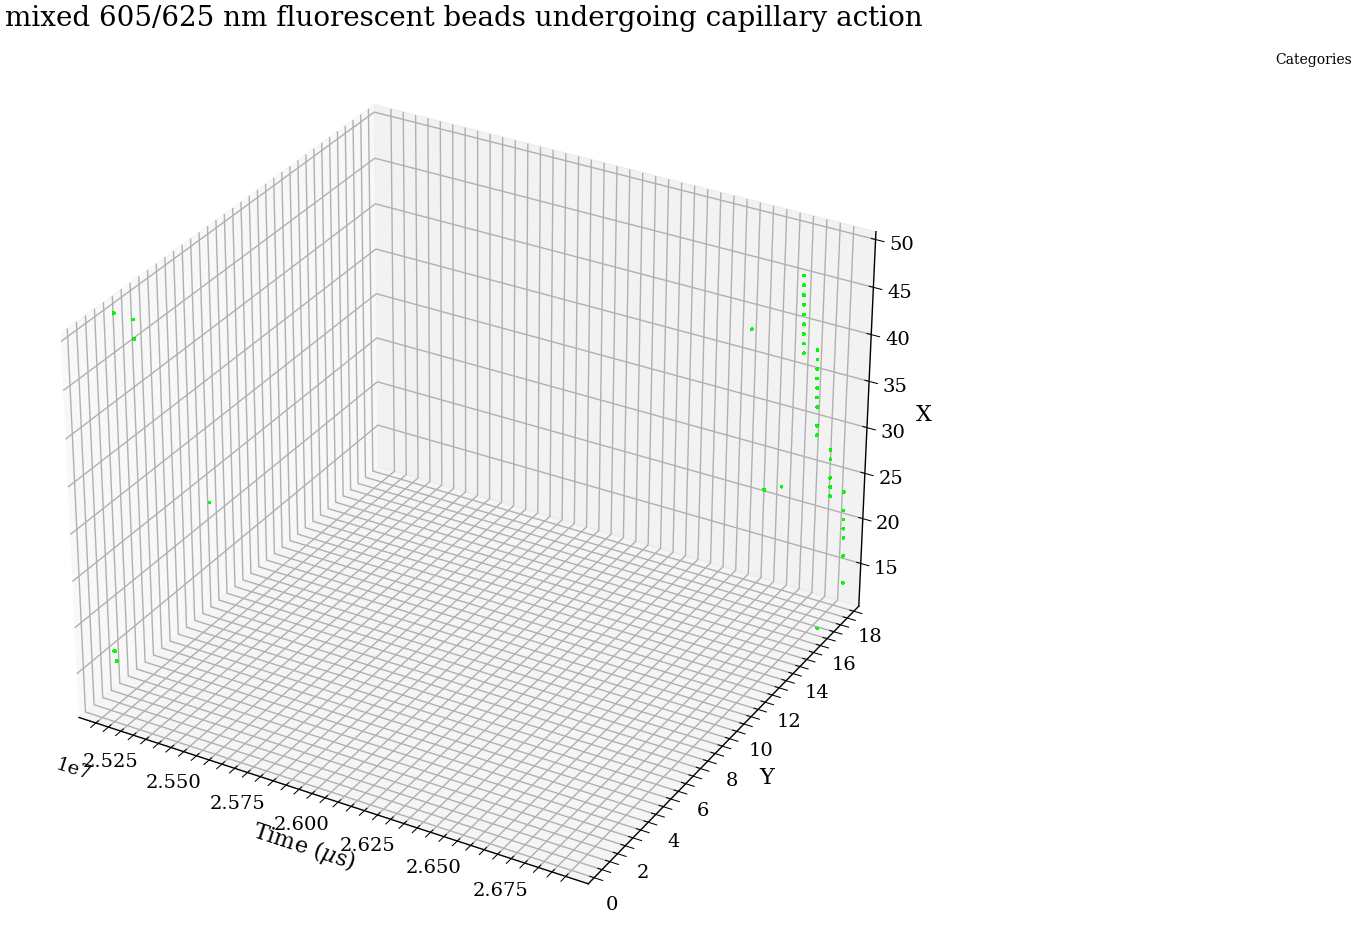

In [22]:
from scipy.spatial import kdtree
import numpy as np
import plotting
from plotting import set_plotting_style
from matplotlib.colors import Normalize
set_plotting_style(plt)

print(len(to_plot))

def category_label(category):
    if category == 0:
        return 'Uncategorized'
    if category == 1:
        return '625 nm'
    if category == 2:
        return '605 nm'

fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(111, projection='3d')
ax.set_ylabel('Y')
ax.set_xlabel(r'Time ($\mu$s)', rotation=90)
ax.set_zlabel('X')
ax.ticklabel_format(style='scientific', axis='x', scilimits=(0, 0))
ax.set_title('mixed 605/625 nm fluorescent beads undergoing capillary action')
# loop through every event in X, load the point from the event_point_map, collect the x, y values from the point, and the t value from the event
# then plot the points
# shift the x axis label down


tracked_uncategorized_points = set()

for event, points in tqdm(to_plot, desc='Assigning categories using trajectories', unit='events'):
    categories = np.unique([p.category for p in points if p.category != 0])
    category = 0
    if len(categories) == 0:
        # Track uncategorized points to try and categorize later
        tracked_uncategorized_points.update(points)
        continue
    elif len(categories) == 1:
        category = categories[0]
    else:
        # Find closest categorized point to determine the category
        categorized_points = [p for p in points if p.category != 0]
        closest_point = min(
            categorized_points, 
            key=lambda p: np.linalg.norm(np.array([map_cmos_to_ebis(p.x), map_cmos_to_ebis(p.y)]) - np.array([event['center_x'], event['center_y']])))
        category = closest_point.category

    # Assign category to current uncategorized points and previously tracked points
    uncategorized = [p for p in points if p.category == 0]
    uncategorized += list(tracked_uncategorized_points)

    for uncategorized_point in uncategorized:
        uncategorized_point.category = category

    # Reset tracked uncategorized points once they have been categorized
    tracked_uncategorized_points.clear()

print(f'Uncategorized points: {len(tracked_uncategorized_points)}')
# Define your category to color mapping as a dictionary
plot_points = []
for event, points in to_plot:
    for point in points:
        _points = (event['center_x'], event['center_y'], event['t'], point.category)
        plot_points.append(_points)

# Function to map a category to a color (R, G, B format)
def get_color(category):
    category_colors = {
        2: [1, 0, 0],  # Red for 605 nm (R, G, B)
        1: [0, 0, 1],  # Blue for 625 nm (R, G, B)
        0: [0, 1, 0],    # Green for uncategorized (0 is uncategorized)
    }
    return category_colors.get(category, [0, 0, 0])  # Default to black if category not found
# convert plot_points to a structured array
plot_points = np.array(plot_points, dtype=[('x', np.uint32), ('y', np.uint32), ('t', np.float32), ('category', np.uint8)])
colors = np.array([get_color(category) for category in plot_points['category']])
# Create the 3D scatter plot
sc = ax.scatter3D(plot_points['t'], plot_points['y'], plot_points['x'], c=colors, s=1)

# Set up the rest of your plot (legend, labels, etc.)
handles = [
    plt.Line2D([0], [0], marker='o', color=get_color(category), linestyle='', markersize=10, label=category_label(category))
    for category in categories
]
ax.legend(handles=handles, title='Categories', loc='upper right', bbox_to_anchor=(1.5, 1))

#plt.tight_layout()
plt.margins(0, 0, 0)
#ax.set_box_aspect([1, 1, 1])
#ax.set_proj_type('ortho')
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def gaussian_2d(shape, center, size=5, sigma=2):
    """Create a 2D Gaussian distribution."""
    x = np.arange(0, shape[1], 1, float)
    y = np.arange(0, shape[0], 1, float)
    x, y = np.meshgrid(x, y)
    
    # Gaussian formula
    d = np.sqrt((x - center[1])**2 + (y - center[0])**2)
    g = np.exp(-( (d)**2 / ( micron_to_pixel(size, 3.45, 38) * sigma**2 ) ) )
    
    return g

# Example: Querying for points
events = [t[0] for t in to_plot]
_tree = kdtree.KDTree([(c['x'], c['y'], c['t']) for c in events], leafsize=16)

query_point = (100, 200, 2.5e7)
dist, idx = _tree.query(query_point)

points = to_plot[idx][1]
event = to_plot[idx][0]
print(f"Closest event: {event['t']}")
results = set()
for point in points:
    results.add(point.result)

if len(results) > 1:
    results = sorted(results, key=lambda x: len(x.patches), reverse=True)
    result = results[0]
else:
    result = results.pop()

print(result.img_path)
process_image(result.img_path, patch_size=8)
img = np.array(result.load_image()).astype(np.float32)
img /= np.max(img)

# Prepare the Gaussian overlay
gaussians = np.zeros_like(img, dtype=np.float32)

# Color mapping for categories
color_map = {1: (0, 0, 1),  # Blue for category 1
             2: (1, 0, 0)}  # Red for category 2

# Create color Gaussian overlays for each channel
color_gaussians = np.zeros((*gaussians.shape, 3), dtype=np.float32)  # To hold colored Gaussian image

for patch in result.patches:
    x, y = patch.centroid
    category = patch.category
    print(map_cmos_to_ebis(np.array(patch.centroid), 'pixel', 'pixel'), patch.t, category)
    # Only process if the category is either 1 or 2
    if category in color_map:
        g = gaussian_2d(gaussians.shape, (y, x))
        g /= np.max(g)  # Normalize each Gaussian
        
        # Get the corresponding color for the category
        r, gr, b = color_map[category]
        
        # Add Gaussian contribution to the color channels
        color_gaussians[..., 0] += g * r  # Red channel
        color_gaussians[..., 1] += g * gr  # Green channel
        color_gaussians[..., 2] += g * b  # Blue channel

# Plotting
fig, ax = plt.subplots(figsize=(10, 5))

# Show the colored Gaussian image
ax.imshow(color_gaussians)

# Hide axes
plt.axis('off')
plt.show()


In [ ]:
def gaussian_2d(shape, center, size=5, sigma=2):
    """Create a 2D Gaussian distribution."""
    x = np.arange(0, shape[1], 1, float)
    y = np.arange(0, shape[0], 1, float)
    x, y = np.meshgrid(x, y)
    
    # Gaussian formula
    d = np.sqrt((x - center[1])**2 + (y - center[0])**2)
    g = np.exp(-( (d)**2 / ( micron_to_pixel(size, 3.45, 38) * sigma**2 ) ) )
    
    return g

img_path = r"D:\CZI_scope\code\preprocess\capillary\imgs\image_20240730_134958_035754.tif"
result = send_image_for_segmentation(img_path, 402260, patch_size=64, deviations=2, threshold=0.2)
img = np.array(result.load_image()).astype(np.float32)
# Prepare the Gaussian overlay
gaussians = np.zeros_like(img, dtype=np.float32)

# Color mapping for categories
color_map = {1: (0, 0, 1),  # Blue for category 1
             2: (1, 0, 0)}  # Red for category 2

# Create color Gaussian overlays for each channel
color_gaussians = np.zeros((*gaussians.shape, 3), dtype=np.float32)  # To hold colored Gaussian image

for patch in result.patches:
    x, y = patch.centroid
    category = patch.category
    print(map_cmos_to_ebis(np.array(patch.centroid), 'pixel', 'pixel'), patch.t, category)
    # Only process if the category is either 1 or 2
    if category in color_map:
        g = gaussian_2d(gaussians.shape, (y, x))
        g /= np.max(g)  # Normalize each Gaussian
        
        # Get the corresponding color for the category
        r, gr, b = color_map[category]
        
        # Add Gaussian contribution to the color channels
        color_gaussians[..., 0] += g * r  # Red channel
        color_gaussians[..., 1] += g * gr  # Green channel
        color_gaussians[..., 2] += g * b  # Blue channel

# Plotting
fig, ax = plt.subplots(figsize=(10, 5))

# Show the colored Gaussian image
ax.imshow(color_gaussians)

# Hide axes
plt.axis('off')
plt.show()

